## Dataset Building

In [2]:
#Importing the neceassary moduels
from PIL import Image #for image related manipulations
import numpy as np #for performing various mathematical operations
import glob #used to retrieve files/pathnames matching a specified pattern

#defining the function to build dataset from source image files
def build_dataset():
    org_dataset = [] #creating empty list to use
    
    for i in range(1, 16):
        filelist = glob.glob('./data/subject'+str(i).zfill(2)+"*") #finds all the files with Subject string
        for fname in filelist: #looping all the files
            img = np.array(Image.open(fname)) #Opening an image and converting it to np.array
            img = img.reshape(img.shape[0]*img.shape[1]) #reshaping the image to be used in next code
            org_dataset.append(img) #appending the reshaped image to dataset_list

    org_dataset = np.array(org_dataset) #convert the dataset into an np.array
    
    return org_dataset #function will return this list

org_dataset = build_dataset() #calling function to build dataset
num_components = len(org_dataset) #store length of the dataset to a variable

## Subtracting the mean vector for normalizing data

In [20]:
#function to normalize the dataset
def normalize(org_dataset):
    mean_vector = np.mean(org_dataset, axis=0) #find mean of the dataset 
    dataset = org_dataset - mean_vector #subtract the mean from original data points

    return dataset, mean_vector #return both dataset and mean_vector file

dataset, mean_vector = normalize(org_dataset)

## Calculating eigen vectors and eigen values

In [21]:
from numpy import linalg as la #importing linear algebra section from Numpy

#function to calculate eigen values
def calc_eig_val_vec(dataset): #passing the dataset to function
    cov_mat = np.dot(dataset, dataset.T) #find the dot product
    eig_values, eigen_vectors = la.eig(cov_mat) #tupple unpacking to store values in two variables
    eig_vectors = np.dot(dataset.T, eigen_vectors) #now use dot product to calculate eigen vectors
    for i in range(eig_vectors.shape[1]): #loop on eig vectors
        eig_vectors[:, i] = eig_vectors[:, i]/la.norm(eig_vectors[:, i])
    return eig_values.astype(float), eig_vectors.astype(float)

eig_values, eig_vectors = calc_eig_val_vec(dataset) #calling function to get eig values and vectors

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


## FInding the 'K' Eigen Faces

In [22]:
#function to use Principal Components Analysis
def pca(eig_values, eig_vectors, k):
    k_eig_val = eig_values.argsort()[-k:][::-1]
    eigen_faces = [] #create empty list
    
    for i in k_eig_val: #looping and appending the vectors to the eigen values list
        eigen_faces.append(eig_vectors[:, i])

    eigen_faces = np.array(eigen_faces) #convert to np.array
    
    return eigen_faces #return eigen faces

eigen_faces = pca(eig_values, eig_vectors, num_components) #function call to PCA

## Reconstructing the Images

In [23]:
def reconstruct_images(eigen_faces, mean_vector):
    '''
    input: eigen faces and mean vector
    output: reconstructed images
    '''
    org_dim_eig_faces = []
    
    for i in range(eigen_faces.shape[0]): #looping and appending the reshaped images to be reconstructed
        org_dim_eig_faces.append(eigen_faces[i].reshape(243, 320))

    org_dim_eig_faces = np.array(org_dim_eig_faces) #convert to array
    
    return org_dim_eig_faces #return the list by function

org_dim_eig_faces = reconstruct_images(eigen_faces, mean_vector) #function call

## Plot the First Eigen Values for K=10 

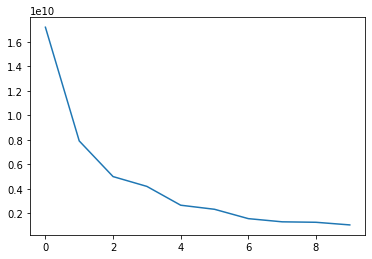

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt # import this to plot graphs

#function that renders the figure in a notebook
%matplotlib inline 
plt.plot(eig_values[:10])
plt.show()
plt.clf()

## Calculate components required to capture 50% energy

In [25]:
from numpy import trapz # Integrate along the given axis using the composite trapezoidal rule

total_energy = trapz(eig_values, dx=1)
print("Total Energy:", total_energy)

k = 0
while True:
    k_energy = trapz(eig_values[:k], dx=1)
    print("Energy captured by", k, "components:", k_energy)
    if k_energy >= 0.5*total_energy:
        break
    k += 1

print("Number of components to capture 50% energy:", k)

Total Energy: 47692294393.44953
Energy captured by 0 components: 0.0
Energy captured by 1 components: 0.0
Energy captured by 2 components: 12546502748.638311
Energy captured by 3 components: 18994191128.318687
Energy captured by 4 components: 23585255322.409756
Energy captured by 5 components: 27007219964.474342
Number of components to capture 50% energy: 5


## Plot top 10 Eigen Faces

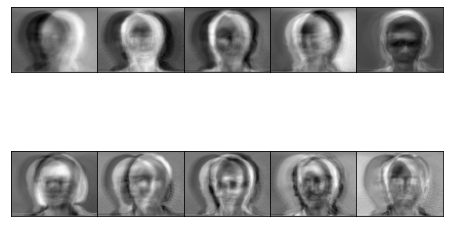

<Figure size 432x288 with 0 Axes>

In [26]:
import matplotlib.gridspec as gridspec #matplotlib.pyplot.subplot() , but creates and places all axes on the gridspace

gs = gridspec.GridSpec(2, 5, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   

#initiate the counter and plot all the faces top 10 faces
i = 0
for g in gs:
    ax = plt.subplot(g) #creating small plots side by side
    ax.imshow(org_dim_eig_faces[i], cmap = plt.get_cmap("gray"))
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1

plt.show()
plt.clf()

## Reconstruct 2 Random Images

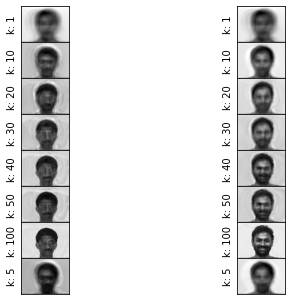

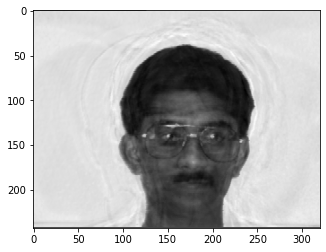

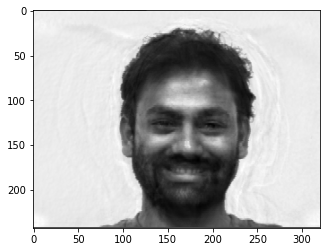

<Figure size 432x288 with 0 Axes>

In [27]:
import random #importing this to use random number generation

k = np.concatenate(([1, 10, 20, 30, 40, 50, 100], [k])) #adding k to the list

r1 = 0
r2 = 0
while r1==r2:
    r1 = random.randint(0, len(dataset)-1) #creating a 11st random number
    r2 = random.randint(0, len(dataset)-1) #creating a second random number

sample1 = dataset[r1] #select 1st random number
sample2 = dataset[r2] #select 2nd random number

def project(org_dim_input, eigen_faces): #function to project the output
    return np.dot(org_dim_input, eigen_faces.T)

def reconstruct(projected_input, eigen_faces): #function for reconstructing the images
    reconstructed_input = []
    reconstructed_input = np.dot(projected_input, eigen_faces) #dot product of projected image and eigen faces
    mean_vector = np.mean(org_dataset, axis=0) #finding mean of the original dataset
    return reconstructed_input + mean_vector #adding the two variables

outputs = [] #empty list to store the output
for j in k: #again looping till the value of K
    projected_input1 = project(sample1, eigen_faces[:j]) #Using the previously defined project function
    reconstructed_input1 = reconstruct(projected_input1, eigen_faces[:j]) #Using the previously defined reconstruct function
    outputs.append(reconstructed_input1) #appending the output to the output lists.

    projected_input2 = project(sample2, eigen_faces[:j]) #repeating the process to reconstruct the second image
    reconstructed_input2 = reconstruct(projected_input2, eigen_faces[:j])
    outputs.append(reconstructed_input2)

gs = gridspec.GridSpec(len(k), 2, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   #define the gridspace

i = 0
for g in gs: #loop through the number of gs and plot the values
    ax = plt.subplot(g)
    plt.ylabel("k: "+str(k[int(i/2)]))
    ax.imshow(outputs[i].reshape(243, 320), cmap = plt.get_cmap("gray")) #reshape and convert to grayscale
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1    

plt.show()
plt.clf()

plt.imshow(outputs[12].reshape(243, 320), cmap = plt.get_cmap("gray")) #reshape and convert to grayscale
plt.show()
plt.clf()

plt.imshow(outputs[13].reshape(243, 320), cmap = plt.get_cmap("gray")) #reshape and convert to grayscale
plt.show()
plt.clf()

# Applyting k-Nearest Neighnor (kNN)

## Training and testing data spliting

In [28]:
train = [] #two empty lists to store the training and testing images
test = []

i = 0
while i!=15: #moving random images to make train and test dataset
    r1 = random.randint(0,10) #generate a number between 0 and 10
    r2 = random.randint(0,10)
    if r1!=r2: #if two random numbers are not equal
        for j in range(11): #select j in 0-11 range
            if j==r1 or j==r2: #if any of random number is equal to the j
                test.append(np.concatenate((org_dataset[i*11+j],[i]))) #append the image to test dataset
                #np.concatenate function is used to join two or more arrays of the same shape along a specified axis
            else:
                train.append(np.concatenate((org_dataset[i*11+j],[i]))) #else append the image to train dataset
        i += 1 #increae the counter value by adding 1 in each iteration

np.random.shuffle(train) #shuffling the training and testing dataset
np.random.shuffle(test) #shuffling the training and testing dataset
        
train = np.array(train) #convert the resulting images to an np.array
test = np.array(test) #convert the resulting images to an np.array

#train_test split....can also be done using sklearn module's train_test_split()
trainX = train[:, :train.shape[1]-1]
testX = test[:, :test.shape[1]-1]
trainY = train[:, train.shape[1]-1]
testY = test[:, test.shape[1]-1]

## Defining kNN methods

In [29]:
#importing other necessary modules
from __future__ import division # will change the / operator to mean true division throughout the module
import sklearn 
from sklearn import preprocessing
from scipy.spatial import distance
import matplotlib.pyplot as plt

def knn(temp_test, temp_train, best_k, temp_train_Y):
    '''
    function to define the KNN model
    input -> testing and training dataset, value of k
    output -> predictions made by model
    '''
    dist = np.ndarray(shape=(len(temp_test), len(temp_train))) #distance finding
    for i in range (0, len(temp_test)):
        for j in range (0, len(temp_train)):
            dist[i][j] = distance.euclidean(temp_test[i], temp_train[j]) #find the euclidean distance
    k_best = np.ndarray(shape=(len(temp_test), best_k)) #find the best value of K
    for i in range (0, len(temp_test)):
        k_best[i] = dist[i].argsort()[:best_k][::1]
    y_pred = np.ndarray(shape=(len(temp_test))) #convert the prediction a np.array
    for i in range (0, len(temp_test)):
        count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for j in range (0, best_k):
            pred_k = temp_train_Y[int(k_best[i][j])] #predict on values of train using best K value
            count[pred_k] += 1 #increase counter everytime
        y_pred[i] = np.argmax(count) #get predictions from model
    return y_pred #return the prediciton

def knn_cross_val(trainX, trainY):
    '''
    function to define Cross Validation
    input: training and testing data
    output: try various K values and return the best
    '''
    k = [3, 5, 7, 9, 11] #list with possible K values
    knn_num_folds = 5 #5 fold cross validation
    knn_cv_acc = np.ndarray(shape=(knn_num_folds, len(k))) # convert the accuracies by cross-validation to an np.array
    n = int(round((len(trainX))/len(k))) #find the number of N

    for i in range (knn_num_folds):
        '''
        check all the possible K values and print accuracies
        '''
        if i==(len(k)-1):
            temp_test = trainX[n*i:]
            temp_test_Y = trainY[n*i:]
            temp_train = trainX[:n*i]
            temp_train_Y = trainY[:n*i]
        elif i==0:
            temp_test = trainX[:n]
            temp_test_Y = trainY[:n]
            temp_train = trainX[n:]
            temp_train_Y = trainY[n:]
        else:
            temp = np.split(trainX, [n*i, n*(i+1)])
            temp_Y = np.split(trainY, [n*i, n*(i+1)])
            temp_test = temp[1]
            temp_train = np.concatenate((temp[0], temp[2]))
            temp_test_Y = temp_Y[1]
            temp_train_Y = np.concatenate((temp_Y[0], temp_Y[2]))
        
        for l in range(len(k)):
            y = knn(temp_test, temp_train, k[l], temp_train_Y)

            c = 0
            for j in range(0, len(temp_test_Y)):
                if temp_test_Y[j]==y[j]:
                    c += 1
            knn_cv_acc[i, l] = c/len(temp_test_Y)

    accuracies = np.mean(knn_cv_acc, axis=0) #finding the mean of all accuracies
    best_k_knn = k[np.argmax(accuracies)]

    return best_k_knn

## Cross-Validation for Finding best k for PCA

In [30]:
def cross_val(trainX, trainY):
    '''
        check all the possible K values and print accuracies
        same as the method used above
    '''
    num_folds = 5
    k = [10, 20, 30, 40, 50]
    cv_acc = np.ndarray((num_folds, len(k)))
    n = int(round((len(trainX))/num_folds))
    
    for i in range(num_folds):
        if i==(num_folds-1):
            temp_test = trainX[n*i:]
            temp_test_Y = trainY[n*i:]
            temp_train = trainX[:n*i]
            temp_train_Y = trainY[:n*i]
        elif i==0:
            temp_test = trainX[:n]
            temp_test_Y = trainY[:n]
            temp_train = trainX[n:]
            temp_train_Y = trainY[n:]
        else:
            temp = np.split(trainX, [n*i, n*(i+1)])
            temp_Y = np.split(trainY, [n*i, n*(i+1)])
            temp_test = temp[1]
            temp_train = np.concatenate((temp[0], temp[2]))
            temp_test_Y = temp_Y[1]
            temp_train_Y = np.concatenate((temp_Y[0], temp_Y[2]))   
            
        for j in range(len(k)):
            t_train = project(temp_train, eigen_faces[:k[j]])
            t_test = project(temp_test, eigen_faces[:k[j]])
        
            t_train = sklearn.preprocessing.normalize(t_train)
            t_test = sklearn.preprocessing.normalize(t_test)
        
            best_k = knn_cross_val(t_train, temp_train_Y)
            
            pred_y = knn(t_test, t_train, best_k, temp_train_Y)
            
            c = 0
            for m in range(0, len(temp_test_Y)):
                if temp_test_Y[m]==pred_y[m]:
                    c += 1

            cv_acc[i, j] = c/len(temp_test_Y)
    
    accuracies = np.mean(cv_acc, axis=0) #calculate the mean value of cross validation accuracies
    best_k_pca = k[np.argmax(accuracies)]
    
    return best_k_pca

best_k_pca = cross_val(trainX, trainY) #find the best value of K and prit it
print("Best k for PCA:", best_k_pca)

projected_trainX = project(trainX, eigen_faces[:best_k_pca])
projected_testX = project(testX, eigen_faces[:best_k_pca])

trainX_norm = sklearn.preprocessing.normalize(projected_trainX) #normalize training and testing dataset
testX_norm = sklearn.preprocessing.normalize(projected_testX)

best_k = knn_cross_val(trainX_norm, trainY) #best k value
pred_y = knn(testX_norm, trainX_norm, best_k, trainY) #finding the predictions

c = 0
for j in range(0, len(testY)): #calculating accuracies if the prediction matches the original labels
    if testY[j]==pred_y[j]:
        c += 1

accuracy = c/len(testY)
print("Test accuracy:", accuracy)

Best k for PCA: 40
Test accuracy: 0.7666666666666667


## Testing random test image 

Test image:


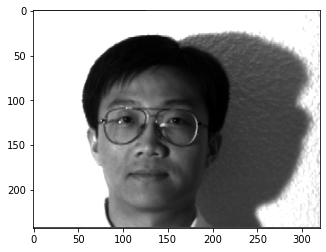

Face recognized is of subject01


<Figure size 432x288 with 0 Axes>

In [31]:
r = random.randint(0, len(testX)-2) #choose a random image from testing dataset

print("Test image:")
plt.imshow(testX[r].reshape(243, 320), cmap = plt.get_cmap("gray")) #reshape and convert to grayscale
plt.show()
plt.clf()

print("Face recognized is of subject"+str(int(pred_y[r]+1)).zfill(2)) #making prediction ysing predict function